# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import torch
import numpy as np
from dppg_agent import Agent 
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.1544999965466559


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
def ddpg(n_episodes=400, max_t = 1000, deque_size=100):

    scores_deque = deque(maxlen=deque_size) 
    scores = []     
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        agent.reset() 
        episode_scores = np.zeros(num_agents) 

        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent.step(states=states, actions=actions, rewards=rewards, next_states=next_states, dones=dones)
            episode_scores += np.array(rewards)
            states = next_states
            if np.any(dones):
                break

        scores_deque.append(np.mean(episode_scores))
        scores.append(np.mean(episode_scores))
        average_score = np.mean(scores_deque)

        # if i_episode % 10 == 0:
        print('\rEpisode: {}\tAverage Score: {}'.format(i_episode, average_score))
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

    return scores

In [8]:
agent = Agent(state_size=state_size, 
              action_size=action_size, 
              n_agents=num_agents, 
              seed=42)

In [9]:
scores = ddpg()

C:\tools\Anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 1	Average Score: 0.22899999488145112
Episode: 2	Average Score: 0.1947499956469983
Episode: 3	Average Score: 0.13916666355604926
Episode: 4	Average Score: 0.11024999753572047
Episode: 5	Average Score: 0.09139999795705081
Episode: 6	Average Score: 0.09474999788217248
Episode: 7	Average Score: 0.10585714049105134
Episode: 8	Average Score: 0.12249999726191163
Episode: 9	Average Score: 0.11933333066602549
Episode: 10	Average Score: 0.13294999702833593
Episode: 11	Average Score: 0.1359999969601631
Episode: 12	Average Score: 0.16620832961828758
Episode: 13	Average Score: 0.19926922631521635
Episode: 14	Average Score: 0.23271428051271606
Episode: 15	Average Score: 0.2730999938957393
Episode: 16	Average Score: 0.3143124929745682
Episode: 17	Average Score: 0.34714705106418803
Episode: 18	Average Score: 0.37311110277142795
Episode: 19	Average Score: 0.4038420962365835
Episode: 20	Average Score: 0.45189998989924796
Episode: 21	Average Score: 0.4814047511445271
Episode: 22	Average Score: 0

Episode: 179	Average Score: 23.84298446706776
Episode: 180	Average Score: 24.068194462033922
Episode: 181	Average Score: 24.297554456907324
Episode: 182	Average Score: 24.52974945171736
Episode: 183	Average Score: 24.770479446336626
Episode: 184	Average Score: 24.986014441519046
Episode: 185	Average Score: 25.216869436359037
Episode: 186	Average Score: 25.44542443125044
Episode: 187	Average Score: 25.654354426580486
Episode: 188	Average Score: 25.86263942192495
Episode: 189	Average Score: 26.05908941753395
Episode: 190	Average Score: 26.249504413277837
Episode: 191	Average Score: 26.454189408702778
Episode: 192	Average Score: 26.651419404294337
Episode: 193	Average Score: 26.85272939979471
Episode: 194	Average Score: 27.066979395005852
Episode: 195	Average Score: 27.26716439053137
Episode: 196	Average Score: 27.47821438581404
Episode: 197	Average Score: 27.695389380959796
Episode: 198	Average Score: 27.90231437633466
Episode: 199	Average Score: 28.09739437197428
Episode: 200	Average Sc

Episode: 356	Average Score: 34.3462892323006
Episode: 357	Average Score: 34.32908923268504
Episode: 358	Average Score: 34.31660423296411
Episode: 359	Average Score: 34.305269233217466
Episode: 360	Average Score: 34.297504233391024
Episode: 361	Average Score: 34.276399233862755
Episode: 362	Average Score: 34.2658792340979
Episode: 363	Average Score: 34.24477423456963
Episode: 364	Average Score: 34.20848423538078
Episode: 365	Average Score: 34.18909923581407
Episode: 366	Average Score: 34.141189236884934
Episode: 367	Average Score: 34.10149423777219
Episode: 368	Average Score: 34.07254923841916
Episode: 369	Average Score: 34.047664238975386
Episode: 370	Average Score: 34.011269239788874
Episode: 371	Average Score: 33.988929240288215
Episode: 372	Average Score: 33.95844924096949
Episode: 373	Average Score: 33.912279242001475
Episode: 374	Average Score: 33.86810924298875
Episode: 375	Average Score: 33.838869243642314
Episode: 376	Average Score: 33.80516924439557
Episode: 377	Average Score:

The agent was able to reach a score of 30 at its 210th episode and was able to maintaina  score > 30 till 400th episode.
### Plot of Rewards

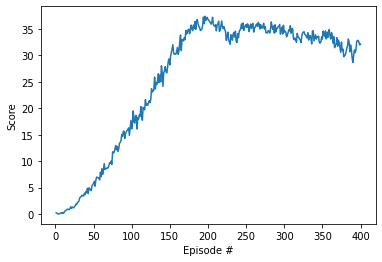

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Loading the saved actor-critic model and testing it out 

In [17]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth')) 
        
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
for t in range(200):
    actions = agent.act(states, add_noise=False)
    env_info = env.step(actions)[brain_name]
    states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    if np.any(dones):
        break

C:\tools\Anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


When finished, you can close the environment.

In [18]:
env.close()